In [228]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
from seaborn import heatmap
from matplotlib import transforms

In [154]:
frameSize=2048
hopSize=512

figScale = 0.75

In [143]:
def importAudio(target, reference):
    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)

    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [87]:
def plotSpectrogram(audio):
    spectrogram = librosa.power_to_db(np.abs(audio["STFT"])**2, ref=np.max)

    plt.figure(figsize=(10*figScale,4*figScale))
    librosa.display.specshow(spectrogram,sr=audio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma")
    plt.colorbar(format='%+2.0f dB')

In [5]:
def exportAudio(audio):
    inverse = librosa.istft(audio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(inverse, rate=audio["sampleRate"]))

<h3>Matching based on gain average of frequency bands</h3>

In [ ]:
def plotFrequencyResponse(tAudio, rAudio, mAudio):
    tResponse = np.transpose(np.array([np.ravel(tAudio["DFT"]),np.ravel(tAudio["DFT"])]))
    tSpectrogram = librosa.power_to_db(np.abs(tResponse)**2, ref=np.max)

    mResponse = np.transpose(np.array([np.ravel(mAudio["DFT"]),np.ravel(mAudio["DFT"])]))
    mSpectrogram = librosa.power_to_db(np.abs(mResponse)**2, ref=np.max)
    
    rResponse = np.transpose(np.array([np.ravel(rAudio["DFT"]),np.ravel(rAudio["DFT"])]))
    rSpectrogram = librosa.power_to_db(np.abs(rResponse)**2, ref=np.max)

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10*figScale, 4*figScale))
    img1 = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,y_axis="mel",cmap="magma",ax=ax[0])
    img3 = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,y_axis="mel",cmap="magma",ax=ax[1])
    img2 = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,y_axis="mel",cmap="magma",ax=ax[2])

    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')

    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(img1, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')

def plotBinScale(EQCurve,EQCurveSmooth):
    plt.figure(figsize=(10*figScale,4*figScale))
    plt.axhline(1, color='black')
    plt.plot(EQCurve, alpha=0.3, label="Scaling Factor")
    plt.plot(EQCurveSmooth, label="Convolved")
    plt.legend()

In [145]:
def convolve(EQCurve, smoothing):
    EQCurve = np.ravel(EQCurve)
    kernel = np.ones(smoothing) / smoothing
    EQCurve = np.convolve(EQCurve, kernel, mode='same')
    EQCurve = EQCurve.reshape(len(EQCurve),1)
    return EQCurve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    EQCurve = np.abs(rAudio["DFT"]) / np.abs(tAudio["DFT"])
    EQCurveSmooth = convolve(EQCurve, smoothing)
    
    matchedSTFT = tAudio["STFT"] * EQCurveSmooth
    matchedDFT = tAudio["DFT"] * EQCurveSmooth
    mAudio = {"STFT":matchedSTFT,"DFT":matchedDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        plotFrequencyResponse(tAudio,rAudio,mAudio)
        plotBinScale(EQCurve,EQCurveSmooth)
    
    return mAudio

In [241]:
def dynamicMatching(tAudio,rAudio):
    freqBinNum = 5
    freqBin = np.abs(tAudio["STFT"][freqBinNum,:])
    plt.figure(figsize=(10*figScale,4*figScale))
    plt.plot(freqBin)

    dynamicBins = 50
    dynamicResponse = np.histogram(freqBin,bins=dynamicBins)[0]
    
    plt.figure(figsize=(10*figScale,4*figScale))
    tr = transforms.Affine2D().rotate_deg(90)
    reshape = np.flip(dynamicResponse.reshape(dynamicResponse.shape[0], 1))
    sns = heatmap(reshape)
    plt.show(tr)

In [330]:
def dynamicMatching(tAudio,rAudio):
    freqBinNum = 2
    freqBin = np.abs(tAudio["STFT"][freqBinNum,:])

    dynamicBins = 80
    dynamicResponse = np.histogram(freqBin,bins=dynamicBins)[0]
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10*figScale, 4*figScale), gridspec_kw={'width_ratios': [8, 1]})

    ax[0].plot(freqBin)
    
    tr = transforms.Affine2D().rotate_deg(90)
    reshape = np.flip(dynamicResponse.reshape(dynamicResponse.shape[0], 1))
    sns = heatmap(reshape, ax=ax[1], cmap="magma")
    ax[1].set_xticks([])
    ax[1].set_yticks([])


<h1>Execution</h1>

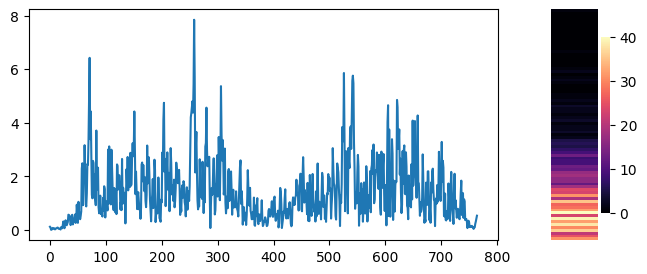

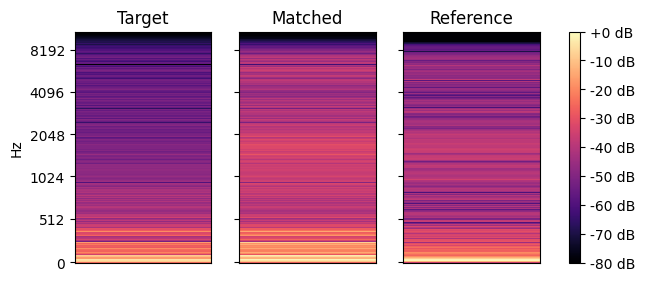

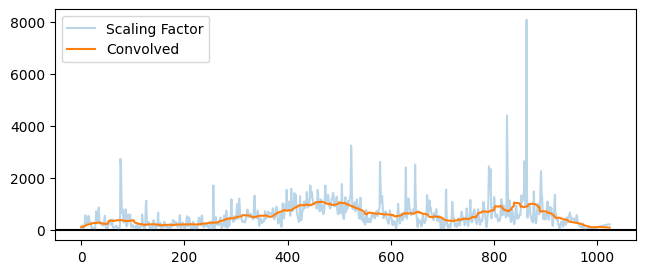

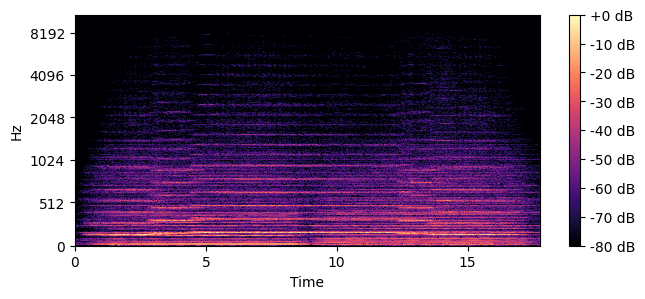

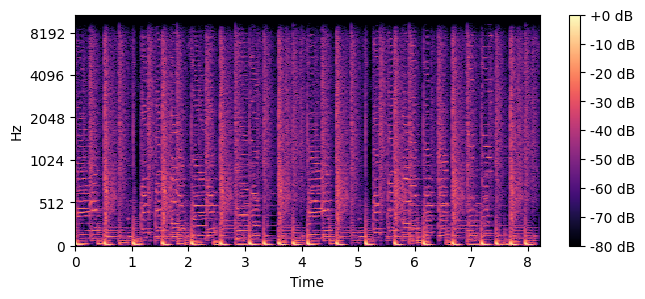

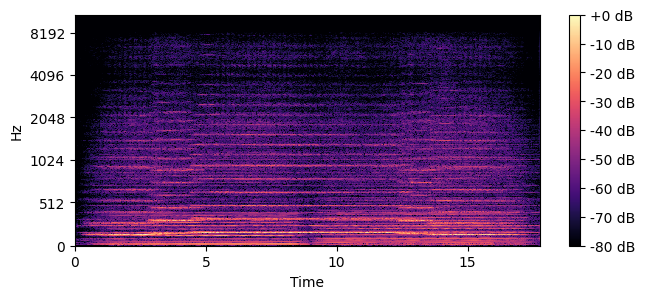

In [332]:
tAudio, rAudio = importAudio("audo3_mono.wav","audio_mono.wav")

dynamicMatching(tAudio,rAudio)
mAudio = EQMatching(tAudio,rAudio,smoothing=50)

plotSpectrogram(tAudio)
plotSpectrogram(rAudio)
plotSpectrogram(mAudio)

In [8]:
exportAudio(tAudio)
exportAudio(rAudio)
exportAudio(mAudio)

In [175]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

data = dynamicResponse

x = np.linspace(1,len(data),num=len(data))
y = data

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="magma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

NameError: name 'dynamicResponse' is not defined